# Introduction

In this notebook, we implement *Latent Credible Analysis* (LCA) models [1] using Pyro. The following LCA models are implemented:

1. SimpleLCA
2. GuessLCA
3. MistakeLCA
4. LieLCA

We will implement these model as probabilistic program written in Pyro and use blackbox variational inference to reason about hidden truths. [1] uses expectation maximization insteads. Our idea is to show that BBVI has the same performance while not requiring modelers' effort of deriving formulas for E and M steps in EM algorithm.

# Problem Definition

In a truth discovery scenario, we have a set of objects. For example, ``the temperature of a room``, or, ``the price of a company share``.  These set of objects has their corresponding values, which are provided by data sources. The aim of truth discovery is to determine the true values and estimate data source reliabilities. To facilitate our subsequent discussion, let's define some notation.

**Data sources**: The set of data sources are denoted as $S = \{s_{id}\}$, where each source is identified uniquely by $s_{id}$.

**Objects**: The set of objects $O = \{o_{id}\}$, where each object is uniquely identified by $o_{id}$. Let's denote the domain of an object values as $dom(o)$.

**Claims**: A claim over an object is an assertion of the object's value by a source, $c_{s,o} = v$, where $v$ is the value. Note that a source can have multiple claims over the same objects with different belief levels $b_{s,c}$. In other words, $\sum_{c \in dom(o)} b_{s,c} = 1$

**Facts**: o represents a true value of an object $o$. Of course, in practice, we do get to observe this value. Instead from the claims, we want to learn a distribution over the domain of this object. The truth value of an object could then be chosen to be the most likely value.
![](./pgm_truthfinding.pdf)






# Population Dataset

In [41]:
import pandas as pd
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
DATA_DIR = '../data'

In [62]:
population_claims = pd.read_csv(op.join(DATA_DIR, 'population/population_claims.csv'))

In [63]:
population_truths = pd.read_csv(op.join(DATA_DIR, 'population/population_truth.csv'))

In [80]:
population_truths.head()

,ObjectID,PropertyID,PropertyValue
0,"cleveland, ohio",Population2000,478403
1,"gary, indiana",Population2000,102746
2,"flint, michigan",Population2000,124943
3,"compton, california",Population2000,93493
4,"washington, d.c.",Population2005,582049


The $o_{id}$ here is the tuple $\{ObjectID, PropertyID\}$

In [78]:
population_truths[population_truths.duplicated(subset=['ObjectID', 'PropertyID'])]

,ObjectID,PropertyID,PropertyValue


In [79]:
population_truths.shape

(308, 3)

In [35]:
cleveland_pop = population_claims[population_claims.ObjectID=='cleveland, ohio'].PropertyValue

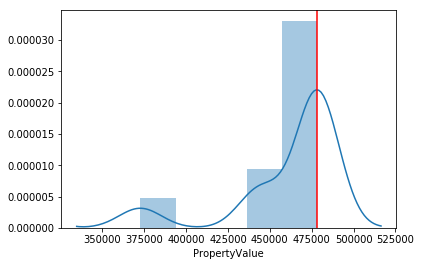

In [45]:
sns.distplot(cleveland_pop)
plt.axvline(478403, 0, 2, color='r')

In [49]:
population_claims[population_claims.ObjectID == 'ventura, california']

,ObjectID,PropertyID,PropertyValue,SourceID,TimeStamp
6832,"ventura, california",Population2000,100916,314721: Howcheng,NaN
6833,"ventura, california",Population2006,105000,0 (75.33.11.215),NaN
6834,"ventura, california",Population2006,106744,0 (205.254.249.253),NaN


### Prepare dataset to feed to model

# Truth Discovery Model

### Simple LCA


In [116]:
import pyro
import pyro.distributions as dists
import torch
import seaborn as sns

In [166]:
def simpleLCA(n_sources, n_objects, object_dim):
    """simple Latent Credible Analysis
    
    Parameters
    ----------
    n_sources: int
        number of sources
        
    n_objects: int
        number of objects. 'Obama is born in'
        
    object_dim: int
        the dimension of each object. We assume for now all objects has the same cardinality for implementation ease.
    """
    # hidden truth rvs.
    truth_probs = pyro.param('truth_probs', torch.ones((n_objects, object_dim))/object_dim) # add parameter constraints here
    hidden_truth = pyro.sample('hidden_truth', dists.Categorical(probs=truth_probs))
    
    # source honesty rvs.
    honesty_probs = pyro.param('source_honesty', torch.ones((n_sources, 2) / 2))
    source = dists.Categorical(probs=honesty_probs)

In [155]:
pyro.clear_param_store()

In [156]:
y_m_dist = simpleLCA(2, 3, 2)

In [161]:
y_m_dist.batch_shape

torch.Size([3])

In [160]:
y_m_dist.sample((10,))

tensor([[0, 1, 0],
        [1, 1, 0],
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])

In [152]:
pyro.param('uniform', torch.ones((2,3))/3)

tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], requires_grad=True)

In [153]:
pyro.get_param_store()['uniform']

tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], requires_grad=True)

In [144]:
truth_probs = pyro.param('truth_theta',torch.tensor([[0.1, 0.1, 0.8], [0.9, 0.05, 0.05]]))

In [145]:
truth_probs

tensor([[0.1000, 0.1000, 0.8000],
        [0.9000, 0.0500, 0.0500]], requires_grad=True)

In [146]:
pyro.get_param_store()['truth_theta']

tensor([[0.1000, 0.1000, 0.8000],
        [0.9000, 0.0500, 0.0500]], requires_grad=True)

In [151]:
params.clear?

Signature: params.clear()
Docstring: Clear the ParamStore
File:      ~/miniconda3/envs/spectrumdev/lib/python3.6/site-packages/pyro/params/param_store.py
Type:      method


In [147]:
truth_dist = simpleLCA(truth_probs=truth_probs)

In [148]:
truth_samples = truth_dist.sample(sample_shape=(10000,))

In [149]:
truth_samples

tensor([[2, 0],
        [2, 0],
        [2, 0],
        ...,
        [0, 2],
        [2, 0],
        [2, 0]])

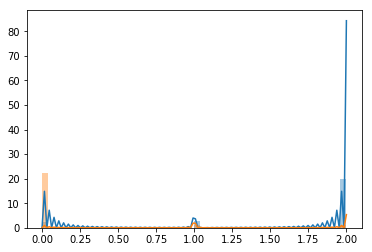

In [150]:
sns.distplot(truth_samples[:,0])
sns.distplot(truth_samples[:,1])



# References

1. Latent Credible Analysis, Jeff Pasternack and Dan Roth
2. Pyro. http://pyro.ai